In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


In [4]:
train_dir = '/Users/gulizkonca/Downloads/images/train'
val_dir = '/Users/gulizkonca/Downloads/images/validation'
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
IMG_SIZE = 48


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=32,
    class_mode='categorical', color_mode='grayscale', subset='training')

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=32,
    class_mode='categorical', color_mode='grayscale', subset='validation')


Found 25942 images belonging to 7 classes.
Found 2879 images belonging to 7 classes.


In [8]:
model_cnn = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(train_generator, epochs=20, validation_data=val_generator)


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


811/811 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.2473 - loss: 1.8219 - val_accuracy: 0.3279 - val_loss: 1.7131
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.3152 - loss: 1.7026 - val_accuracy: 0.3772 - val_loss: 1.6123
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3583 - loss: 1.6317 - val_accuracy: 0.4019 - val_loss: 1.5448
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.3831 - loss: 1.5755 - val_accuracy: 0.4231 - val_loss: 1.4920
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.4013 - loss: 1.5351 - val_accuracy: 0.4415 - val_loss: 1.4401
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.4254 - loss: 1.4964 - val_accuracy: 0.4404 - val_loss: 1.4270
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.4262 - loss: 1.4816 - val_accuracy: 0.4512 - val_loss: 1.3996
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.4314 - loss: 1.4675 - val_accurac

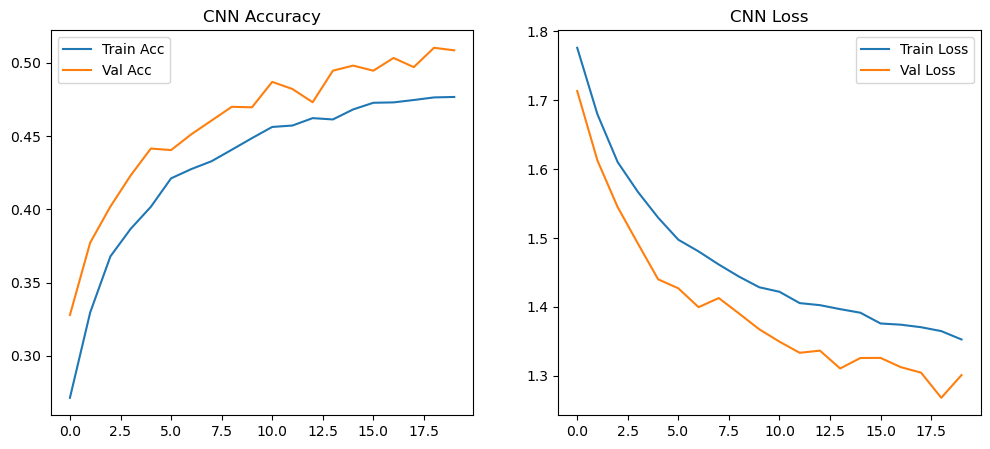

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("CNN Accuracy")

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("CNN Loss")
plt.show()


In [12]:
def load_flat_data(base_path):
    data, labels = [], []
    for label in emotion_labels:
        path = os.path.join(base_path, label)
        for img_file in glob(path + '/*.jpg'):
            img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img.flatten())
                labels.append(label)
    return np.array(data), np.array(labels)

x_data, y_data = load_flat_data(train_dir)
le = LabelEncoder()
y_encoded = le.fit_transform(y_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_encoded, test_size=0.2, random_state=42)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

model_ann = Sequential([
    Input(shape=(IMG_SIZE*IMG_SIZE,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_ann = model_ann.fit(x_train, y_train, epochs=30, validation_split=0.1, verbose=0)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step

ANN Confusion Matrix:


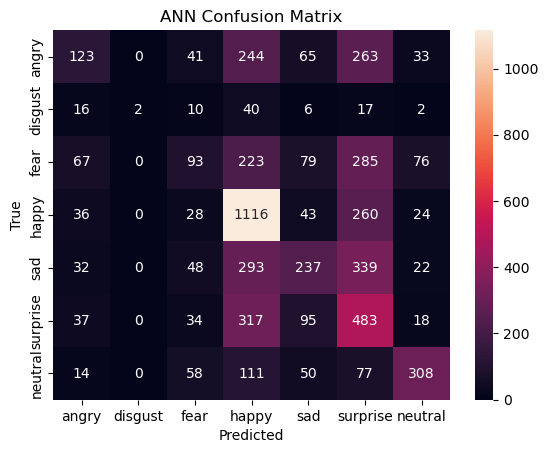


ANN Classification Report:
              precision    recall  f1-score   support

       angry       0.38      0.16      0.22       769
     disgust       1.00      0.02      0.04        93
        fear       0.30      0.11      0.16       823
       happy       0.48      0.74      0.58      1507
         sad       0.41      0.24      0.31       971
    surprise       0.28      0.49      0.36       984
     neutral       0.64      0.50      0.56       618

    accuracy                           0.41      5765
   macro avg       0.50      0.32      0.32      5765
weighted avg       0.42      0.41      0.38      5765



In [13]:
y_ann_pred = np.argmax(model_ann.predict(x_test), axis=1)
print("\nANN Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_ann_pred), annot=True, fmt="d", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("ANN Confusion Matrix"); plt.show()

print("\nANN Classification Report:")
print(classification_report(y_test, y_ann_pred, target_names=emotion_labels, zero_division=0))


In [14]:
def make_sequence_data(x):
    return x.reshape((-1, 1, IMG_SIZE*IMG_SIZE))

x_seq = make_sequence_data(x_data)
x_seq_train, x_seq_test, y_seq_train, y_seq_test = train_test_split(x_seq, y_encoded, test_size=0.2, random_state=42)

model_lstm = Sequential([
    Input(shape=(1, IMG_SIZE*IMG_SIZE)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(x_seq_train, y_seq_train, epochs=20, validation_split=0.1, verbose=0)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step

LSTM Confusion Matrix:


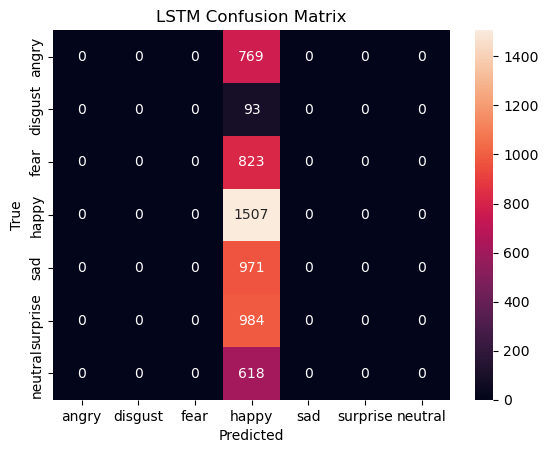


LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       769
     disgust       0.00      0.00      0.00        93
        fear       0.00      0.00      0.00       823
       happy       0.26      1.00      0.41      1507
         sad       0.00      0.00      0.00       971
    surprise       0.00      0.00      0.00       984
     neutral       0.00      0.00      0.00       618

    accuracy                           0.26      5765
   macro avg       0.04      0.14      0.06      5765
weighted avg       0.07      0.26      0.11      5765



In [22]:

!pip install tensorflow scikit-learn seaborn matplotlib



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
 27/721 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2239 - loss: 1.8521 - val_accuracy: 0.2486 - val_loss: 1.8065
Epoch 2/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2502 - loss: 1.8042 - val_accuracy: 0.2486 - val_loss: 1.7886
Epoch 3/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2508 - loss: 1.7875 - val_accuracy: 0.2722 - val_loss: 1.7448
Epoch 4/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2611 - loss: 1.7615 - val_accuracy: 0.3345 - val_loss: 1.7248
Epoch 5/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2876 - loss: 1.7351 - val_accuracy: 0.3274 - val_loss: 1.7029
Epoch 6/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3005 - loss: 1.7073 - val_accuracy: 0.3456 - val_loss: 1.6799
Epoch 7/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2841 - loss: 1.7265 - val_accuracy: 0.3192 - val_loss: 1.6739
Epoch 8/20
721/721 ━━━

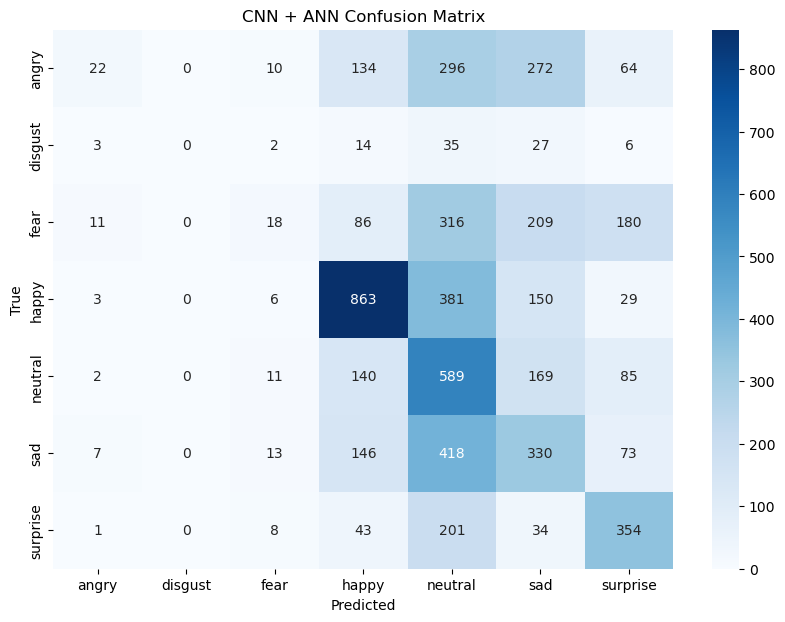

'              precision    recall  f1-score   support\n\n       angry       0.45      0.03      0.05       798\n     disgust       0.00      0.00      0.00        87\n        fear       0.26      0.02      0.04       820\n       happy       0.61      0.60      0.60      1432\n     neutral       0.26      0.59      0.36       996\n         sad       0.28      0.33      0.30       987\n    surprise       0.45      0.55      0.49       641\n\n    accuracy                           0.38      5761\n   macro avg       0.33      0.30      0.27      5761\nweighted avg       0.39      0.38      0.33      5761\n'

In [24]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ayarlar
IMG_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = "/Users/gulizkonca/Downloads/images"

# Data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=False
)

val_gen = datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

# Özellik çıkarımı için basit bir CNN (VGG gibi büyük bir model yerine elle yazılmış katman)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

feature_extractor = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten()
])

# Özellikleri çıkart
features_train = feature_extractor.predict(train_gen)
features_val = feature_extractor.predict(val_gen)

# Etiketleri al
labels_train = train_gen.classes
labels_val = val_gen.classes
num_classes = train_gen.num_classes

# ANN Model
model_ann = Sequential([
    Input(shape=(features_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_ann = model_ann.fit(features_train, labels_train, epochs=EPOCHS, validation_data=(features_val, labels_val), verbose=1)

# Tahmin ve değerlendirme
y_pred_probs = model_ann.predict(features_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix ve Classification Report
cm = confusion_matrix(labels_val, y_pred)
report = classification_report(labels_val, y_pred, zero_division=0, target_names=train_gen.class_indices.keys())

# Görselleştirme
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN + ANN Confusion Matrix")
plt.show()

report
